# Plot gender distribution per year (1990-2023)

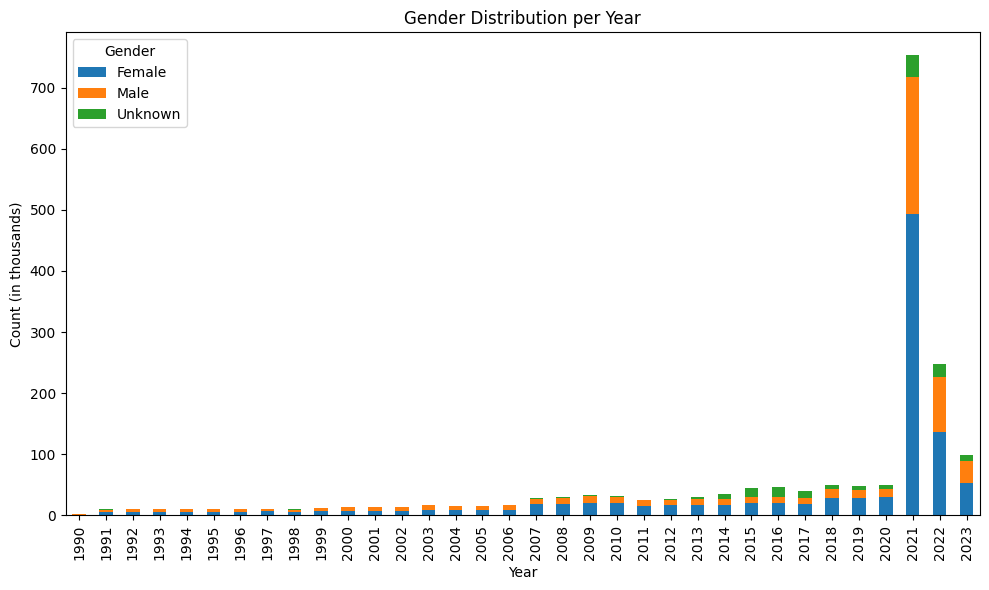

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Custom formatter function to format y-axis values in thousands
def format_with_dot(x, pos):
    return f'{int(x/1000):,}'.replace(',', '.')

# Initialize a dictionary to store the number of entries per year
entries_per_sex = {}

# Loop through each year from 1990 to 2023
for year in range(1990, 2024):
    try:
        # Construct the filename
        path = "/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/"
        filename = f"{year}VAERSDATA.csv"
        
        # Load the CSV file
        data = pd.read_csv(path + filename, encoding="Iso-8859-1", low_memory=False)
        
        # Count the number of entries and store it
        entries_per_sex[year] = data["SEX"].value_counts()
    except FileNotFoundError:
        print(f"File for year {year} not found.")
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Convert the dictionary to a DataFrame
df = pd.DataFrame(entries_per_sex)

# Replace row indices for gender labels
df.index = df.index.map({'M': 'Male', 'F': 'Female', 'U': 'Unknown'})

# Plot the DataFrame as a stacked bar chart
df.T.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Year')
plt.ylabel('Count (in thousands)')
plt.title('Gender Distribution per Year')

# Set the custom formatter for the y-axis
formatter = FuncFormatter(format_with_dot)
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(title='Gender')
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Gender_Distribution/Gender_Distribution_Per_Year.png')
plt.show()


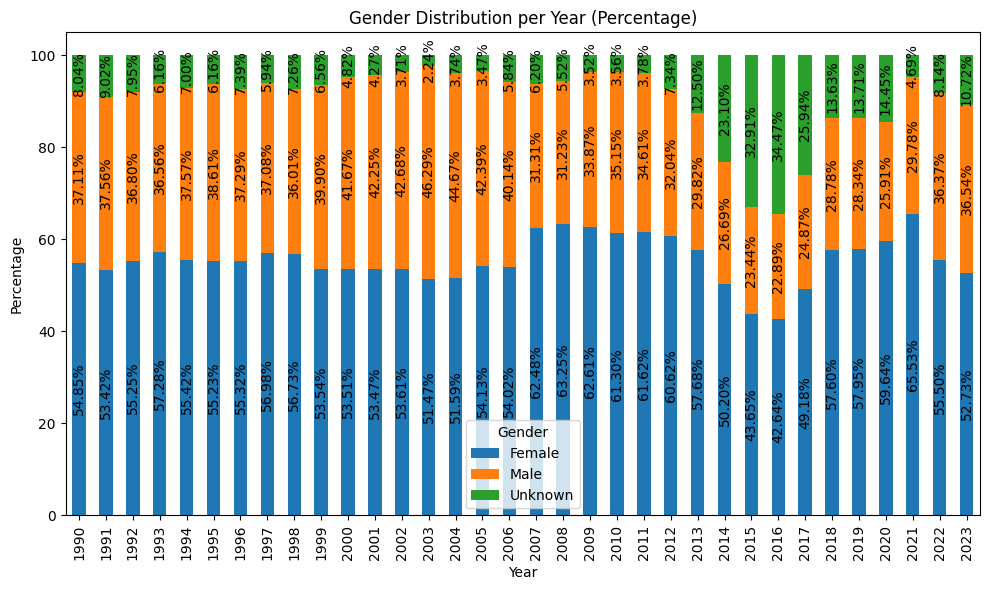

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize a dictionary to store the number of entries per year
entries_per_sex = {}

# Loop through each year from 1990 to 2023
for year in range(1990, 2024):
    try:
        # Construct the filename
        path = "/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/"
        filename = f"{year}VAERSDATA.csv"
        
        # Load the CSV file
        data = pd.read_csv(path + filename, encoding="Iso-8859-1", low_memory=False)
        
        # Count the number of entries and store it as a percentage
        entries_per_sex[year] = data["SEX"].value_counts(normalize=True) * 100
    except FileNotFoundError:
        print(f"File for year {year} not found.")
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Convert the dictionary to a DataFrame
df = pd.DataFrame(entries_per_sex)

# Replace row indices for gender labels
df.index = df.index.map({'M': 'Male', 'F': 'Female', 'U': 'Unknown'})

# Plot the DataFrame as a stacked bar chart
ax = df.T.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Gender Distribution per Year (Percentage)')

# Annotating each bar with the percentage value
for bar in ax.containers:
    ax.bar_label(bar, fmt='%.2f%%', label_type='center', rotation=90)

plt.legend(title='Gender')
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Gender_Distribution/Gender_Distribution_Per_Year.png')
plt.show()

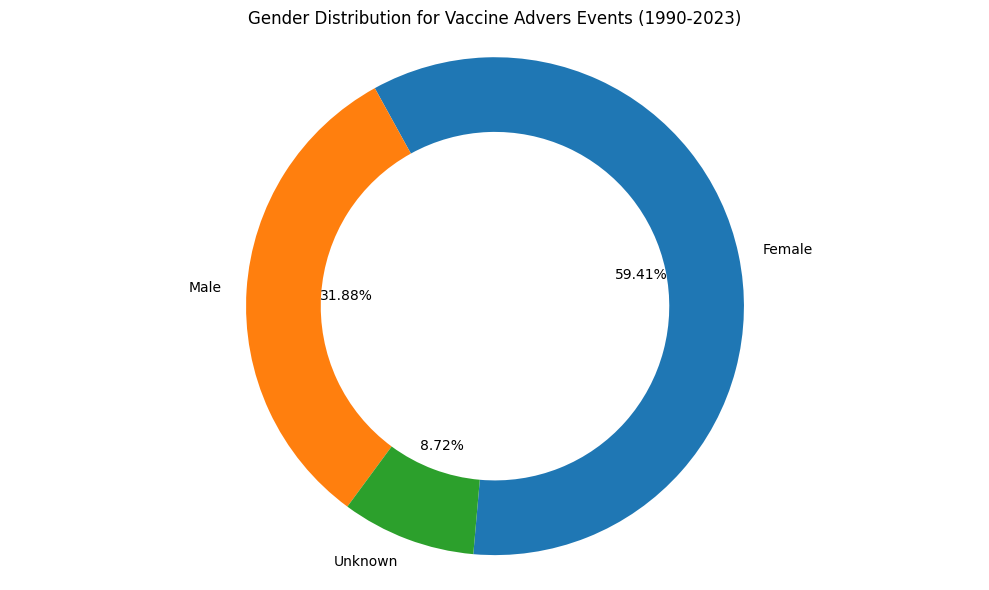

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize a dictionary to store the number of entries per year
entries_per_sex = {}

# Loop through each year from 1990 to 2023
for year in range(1990, 2024):
    try:
        # Construct the filename
        path = "/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/"
        filename = f"{year}VAERSDATA.csv"
        
        # Load the CSV file
        data = pd.read_csv(path + filename, encoding="Iso-8859-1", low_memory=False)
        
        # Count the number of entries and store it as a percentage
        entries_per_sex[year] = data["SEX"].value_counts()
    except FileNotFoundError:
        print(f"File for year {year} not found.")
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Convert the dictionary to a DataFrame
df = pd.DataFrame(entries_per_sex)

# Replace row indices for gender labels
df.index = df.index.map({'M': 'Male', 'F': 'Female', 'U': 'Unknown'})

# Sum the number of entries for each gender across all years
gender_counts = df.sum(axis=1)

# Calculate the total number of entries across all years
total_entries = gender_counts.sum()

# Calculate the percentage for each gender
percentage_gender = (gender_counts / total_entries) * 100

# Define labels
labels = ['Female', 'Male', 'Unknown']
sizes = [percentage_gender['Female'], percentage_gender['Male'], percentage_gender['Unknown']]


plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=265, wedgeprops={'width': 0.3})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Gender Distribution for Vaccine Advers Events (1990-2023)')
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Gender_Distribution/Total_Gender_Distribution_Donut.png')
plt.show()


# Plot gender distribution per year before Covid-19 vaccinations (first vaccinations in Dezember 2020)

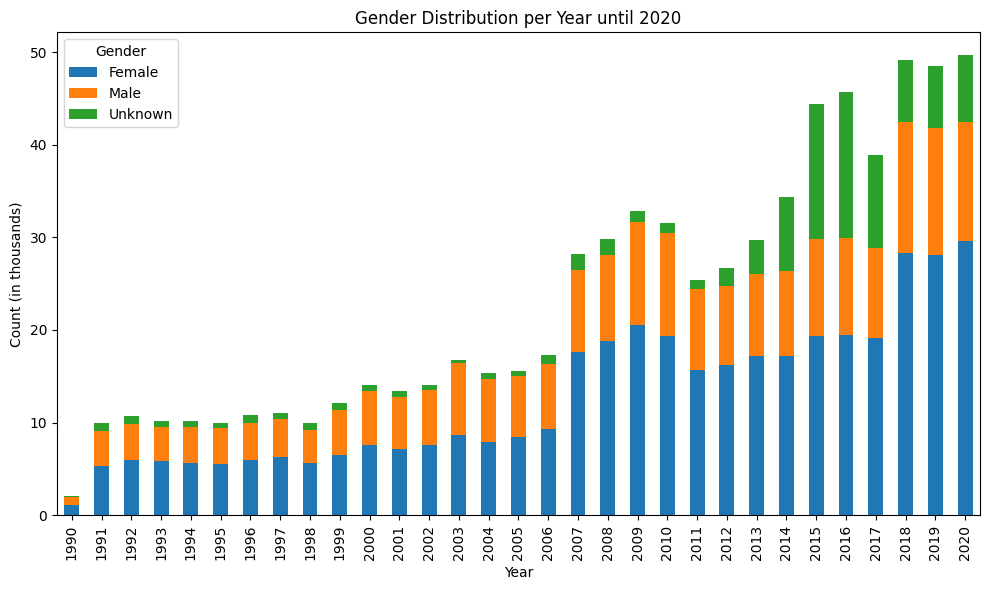

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


# Custom formatter function to format y-axis values in thousands
def format_with_dot(x, pos):
    return f'{int(x / 1000):,}'.replace(',', '.')


# Initialize a dictionary to store the number of entries per year
entries_per_sex = {}

# Loop through each year from 1990 to 2023
for year in range(1990, 2021):
    try:
        # Construct the filename
        path = "/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/"
        filename = f"{year}VAERSDATA.csv"

        # Load the CSV file
        data = pd.read_csv(path + filename, encoding="Iso-8859-1", low_memory=False)

        # Count the number of entries and store it
        entries_per_sex[year] = data["SEX"].value_counts()
    except FileNotFoundError:
        print(f"File for year {year} not found.")
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Convert the dictionary to a DataFrame
df = pd.DataFrame(entries_per_sex)

# Replace row indices for gender labels
df.index = df.index.map({'M': 'Male', 'F': 'Female', 'U': 'Unknown'})

# Plot the DataFrame as a stacked bar chart
df.T.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Year')
plt.ylabel('Count (in thousands)')
plt.title('Gender Distribution per Year until 2020')

# Set the custom formatter for the y-axis
formatter = FuncFormatter(format_with_dot)
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(title='Gender')
plt.tight_layout()
plt.show()

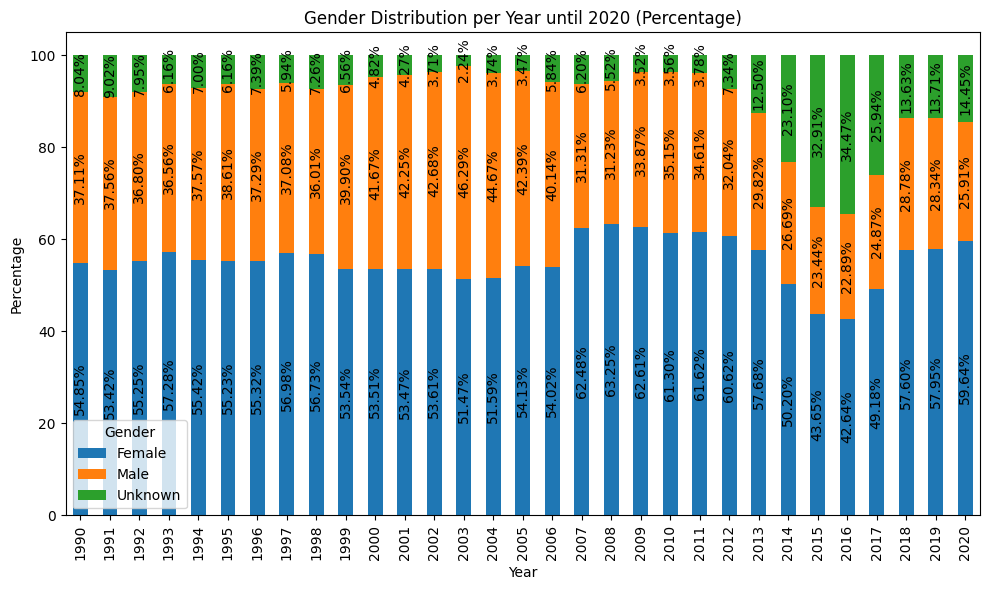

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize a dictionary to store the number of entries per year
entries_per_sex = {}

# Loop through each year from 1990 to 2023
for year in range(1990, 2021):
    try:
        # Construct the filename
        path = "/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/"
        filename = f"{year}VAERSDATA.csv"

        # Load the CSV file
        data = pd.read_csv(path + filename, encoding="Iso-8859-1", low_memory=False)

        # Count the number of entries and store it as a percentage
        entries_per_sex[year] = data["SEX"].value_counts(normalize=True) * 100
    except FileNotFoundError:
        print(f"File for year {year} not found.")
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Convert the dictionary to a DataFrame
df = pd.DataFrame(entries_per_sex)

# Replace row indices for gender labels
df.index = df.index.map({'M': 'Male', 'F': 'Female', 'U': 'Unknown'})

# Plot the DataFrame as a stacked bar chart
ax = df.T.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Gender Distribution per Year until 2020 (Percentage)')

# Annotating each bar with the percentage value
for bar in ax.containers:
    ax.bar_label(bar, fmt='%.2f%%', label_type='center', rotation=90)

plt.legend(title='Gender')
plt.tight_layout()
plt.show()

# Gender distribution for Covid-19 vaccinations

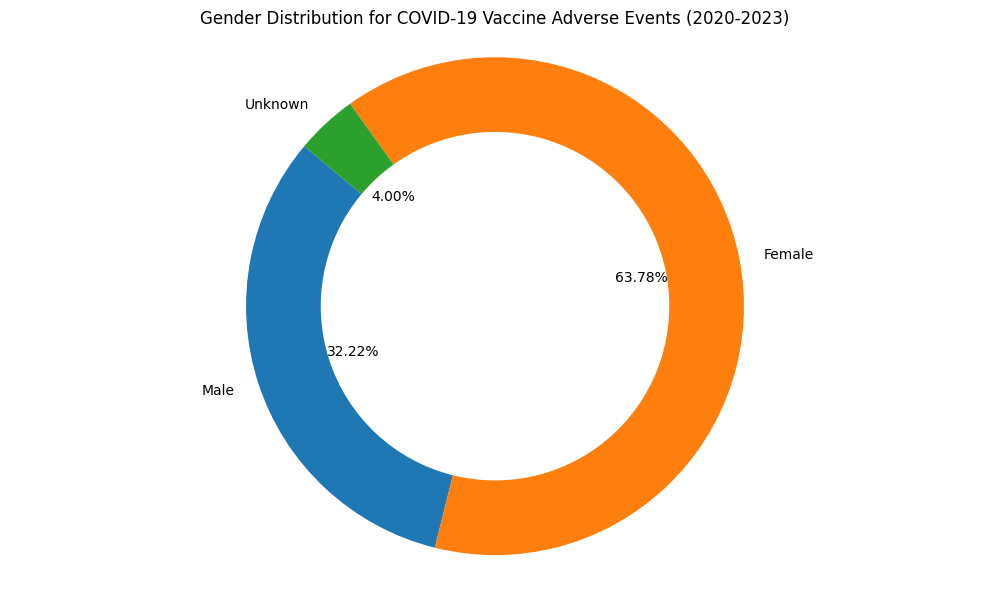

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize a DataFrame to store gender counts
gender_counts = {'Male': 0, 'Female': 0, 'Unknown': 0}

for year in range(2020, 2024):
    # File paths
    data_filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSDATA.csv"
    vax_filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSVAX.csv"
    
    # Load datasets
    data_df = pd.read_csv(data_filename, encoding="Iso-8859-1", low_memory=False, usecols=['VAERS_ID', 'SEX'])
    vax_df = pd.read_csv(vax_filename, encoding="Iso-8859-1", low_memory=False, usecols=['VAERS_ID', 'VAX_TYPE'])
    
    # Filter VAERSVAX for COVID19
    covid_vax_df = vax_df[vax_df['VAX_TYPE'] == 'COVID19']
    
    # Merge datasets on VAERS_ID
    merged_df = pd.merge(data_df, covid_vax_df, on='VAERS_ID')
    
    # Count genders
    gender_distribution = merged_df['SEX'].value_counts()
    for gender in gender_distribution.index:
        if gender == 'M':
            gender_counts['Male'] += gender_distribution[gender]
        elif gender == 'F':
            gender_counts['Female'] += gender_distribution[gender]
        else:  # Assuming all other values are considered Unknown
            gender_counts['Unknown'] += gender_distribution[gender]

# Prepare data for pie chart
labels = gender_counts.keys()
sizes = gender_counts.values()

# Plotting
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=140, wedgeprops={'width': 0.3})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Gender Distribution for COVID-19 Vaccine Adverse Events (2020-2023)')
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Gender_Distribution/Gender_Distribution_Covid_Vaccinations.png')
plt.show()